#### Replicating [Chan et. al 2023](https://ieeexplore.ieee.org/document/10156650/) Fig. 3

Prob. info taken from /src/config/multistage.py --> get_prob_info_exp()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
from copy import *
import scipy.io

### Loading in information

In [3]:
model = scipy.io.loadmat('data/mat/APPJmodel_2021_06_08_15h57m55s_n4sid_alldata.mat') # load in model data

In [4]:
ts = 0.5 # sampling time
Tref = 43.0 # reference temperature
Tmax = 45.0 # max temp. for patient comfort
Np = 5 # prediction horizon
Ns = Np
Kcem = 0.5 

In [5]:
# Linear model used for control
A, B = model['A'], model['B']
C, D = model['C'], 0 # C = identity, D = 0

xss = np.ravel(model['yss']) # use to center data for controller [Ts, I]
uss = np.ravel(model['uss']) # use to center data for controller [P, q]

x0 = np.array([30 - xss[0], 0]) # initial state

In [6]:
nx, nu, ny = A.shape[1], B.shape[1], C.shape[0] # u (P, q), x (Ts, I), y (Ts, I)
nyc = 1 # x (CEM)

In [7]:
# constraint bounds, centered about ss
u_min, u_max = np.array([1.5, 3.5]) - uss, np.array([3.5, 7.5]) - uss
x_min, x_max = np.array([25, 0]) - xss, np.array([Tmax, 80]) - xss
y_min, y_max = x_min, x_max

u_init, x_init, y_init = (u_min + u_max) / 2, (x_min + x_max) / 2, (y_min + y_max) / 2

### Set up controller

In [8]:
opti = Opti()

In [9]:
# casadi functions
x, u, Ts = SX.sym('x', nx), SX.sym('u', nu), SX.sym('Ts', nyc)

In [10]:
# dynamics functions
f = Function('f', [x, u], [A@x + B@u])
h = Function('h', [x], [C@x])

In [11]:
# nonlinear CEM cost
lstg = Kcem ** (Tref - (x[0] + xss[0])) * ts / 60
lstage = Function('lstage', [x], [lstg])

In [13]:
# containers
X = [0 for _ in range(Np + 1)]
U = [0 for _ in range(Np)]
Y = [0 for _ in range(Np + 1)]

In [14]:
J = 0 # init. cost/objective function

In [15]:
CEMref = opti.parameter(nyc) # target/reference output, fixed during optimization
opti.set_value(CEMref, np.zeros((nyc, 1))) # set value of parameter

CEM0 = opti.parameter(nyc) # initial CEM 
opti.set_value(CEM0, np.zeros((nyc, 1))) # set value of initial CEM parameter

In [16]:
X[0] = opti.parameter(nx) # initial state as parameter
opti.set_value(X[0], np.zeros((nx, 1))) # set value of initial state parameter

Y[0] = opti.variable(ny) # output as decision variable 
opti.subject_to(Y[0] == h(X[0])) # define output constraints based on initial state
opti.set_initial(Y[0], y_init) # define initial output 

In [17]:
for k in range(Np): 
    # controller @ k
    U[k] = opti.variable(nu) # controller input as decision variable
    opti.subject_to(opti.bounded(u_min, U[k], u_max)) # define controller input constraints
    opti.set_initial(U[k], u_init) # define initial controller input

    # increment stage cost 
    Jstage = lstage(X[k])
    J += Jstage

    # state @ k+1
    X[k + 1] = opti.variable(nx) # state at k+1 as decision variable
    opti.subject_to(opti.bounded(x_min, X[k + 1], x_max)) # define state constraints
    opti.set_initial(X[k + 1], x_init) # define initial state 

    # output @ k+1
    Y[k + 1] = opti.variable(ny) # output at k+1 as decision variable
    opti.subject_to(opti.bounded(y_min, Y[k +1], y_max)) # define state constraints
    opti.set_initial(Y[k + 1], y_init) # define initial output

    # dynamics constraint
    opti.subject_to(X[k + 1] == f(X[k], U[k]))
    # output equality constraint
    opti.subject_to(Y[k + 1] == h(X[k + 1]))

In [18]:
# calculate the terminal cost, note no splits or iterations
J += lstage(X[-1])

J = (CEMref - (J + CEM0)) ** 2 # eq. 6 control objective 

# minimize cost
opti.minimize(J)

In [19]:
# solver info
p_opts = {'verbose': False, 'expand': True, 'print_time': 0} # options taken from K.C. --> Ipopt options to print to console
s_opts = {'max_iter': 1000, 'print_level': 0, 'tol': 1e-6}

opti.solver('ipopt', p_opts, s_opts)
soln = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [20]:
# prediction values
U_soln = np.asarray([soln.value(u) for u in U]).reshape(-1, nu).T
X_soln = np.asarray([soln.value(x) for x in X]).reshape(-1, nx).T
Y_soln = np.asarray([soln.value(y) for y in Y]).reshape(-1, ny).T

### Run the simulation

In [22]:
U_sim = np.zeros((nu, Ns))
X_sim = np.zeros((nx, Ns + 1))
Y_sim = np.zeros((ny, Ns + 1))

CEMsim = np.zeros((nyc, Ns + 1))

X_sim[:, 0] = np.ravel(x0) # set initial state
Y_sim[:, 0] = np.ravel(h(X_sim[:, 0]).full())
CEMsim[:, 0] = np.zeros((nyc,))

In [23]:
# run closed-loop
for k in range(Ns):
    opti.set_value(X[0], X_sim[:, k]) # set initial state parameters 
    sol = opti.solve() # solve optimization problem
    U_soln = np.asarray([sol.value(u) for u in U]).reshape(nu, -1) # extract control inputs based on state
    Y_soln = np.asarray([sol.value(y) for y in Y]).reshape(ny, -1) # extract outputs based on state

    U_sim[:, k] = U_soln[:, 0] # for control, only interested in the first opt. control input
    
    X_sim[:, k + 1] = np.ravel(f(X_sim[:, k], U_sim[:, k]).full()) # apply input to state system/plant
    Y_sim[:, k + 1] = np.ravel(h(X_sim[:, k + 1]).full()) # apply input to output system/plant

    CEMsim[:, k + 1] = CEMsim[:, k] + np.ravel(lstage(X_sim[:, k + 1]).full())

### Plotting

State and input profiles of closed-loop experiments for a single iteration

States  X (CEM, Ts)

Control U (P  , q )

In [25]:
X_sim

array([[-3.306     , -1.97640911, -0.73095626,  0.38911731,  1.37944798,
         2.2364831 ],
       [ 0.        ,  4.15517048,  5.20176125,  5.5093169 ,  5.6046619 ,
         5.57310903]])

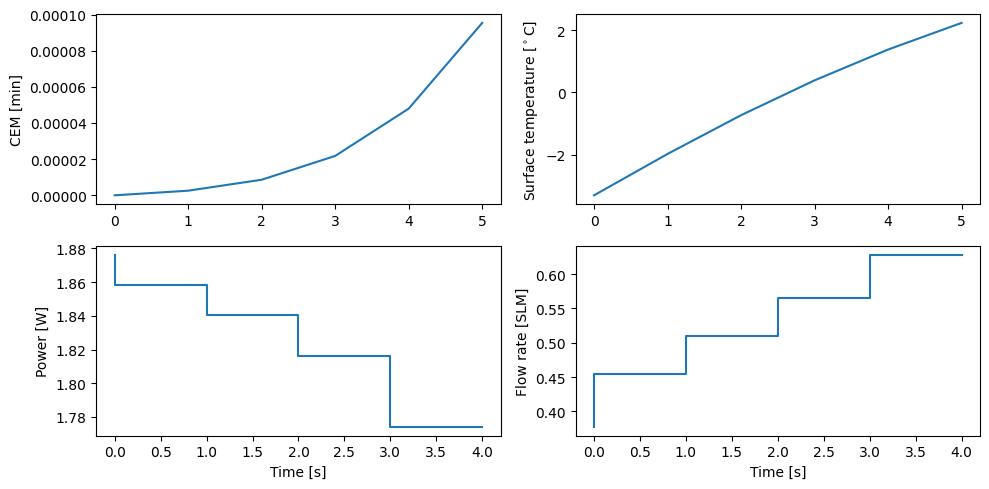

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 5)) 

# CEM
ax1.plot(np.arange(CEMsim.shape[1]), np.ravel(CEMsim))
ax1.set_ylabel('CEM [min]')
# Ts
ax2.plot(np.arange(X_sim[0].shape[0]), np.ravel(X_sim[0]))
ax2.set_ylabel('Surface temperature [$^\circ$C]')
# P
ax3.step(np.arange(U_sim[0].shape[0]), np.ravel(U_sim[0]))
ax3.set_ylabel('Power [W]')
ax3.set_xlabel('Time [s]')
# q
ax4.step(np.arange(U_sim[1].shape[0]), np.ravel(U_sim[1]))
ax4.set_ylabel('Flow rate [SLM]')
ax4.set_xlabel('Time [s]')

plt.tight_layout()

In [26]:
uss

array([1.5, 3.5])

In [27]:
1.5+1.8

3.3